In [1]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import os.path as op
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval
%matplotlib qt

In [2]:
input_path='/Users/huseyinelmas/CCNLAB/BioPrediction/EEG_data/'
file_name = 'sezan3_17_05_ft_refFCz_removeBads_avgReref_ica_finrej.set'
participant_name='sezan3_17_05'
events_path='/Users/huseyinelmas/CCNLAB/BioPrediction/EEG_data/sezan3_17_05/eeg/sezan3_events.txt'

In [3]:
data = pd.read_csv(events_path, delim_whitespace=True, header=None, dtype=int )
events = data[[1, 3, 5]]
events = events.to_numpy(dtype=int)

In [4]:
event_dict = { "Congruent/Left/Walk":11,"Congruent/Left/Kick":12, "Congruent/Right/Walk":13, "Congruent/Right/Kick":14, 
              "Incongruent/Left/Walk":21, "Incongruent/Left/Kick":22,"Incongruent/Right/Walk":23,"Incongruent/Right/Kick": 24,
              "Neutral/Left/Walk":31,"Neutral/Left/Kick":32, "Neutral/Right/Walk":33, "Neutral/Right/Kick":34 };



In [18]:
epoched_data = mne.io.read_epochs_eeglab(input_path +participant_name + '/processed/' + file_name, events=events,event_id=event_dict)
epoched_data.apply_baseline(baseline =(-2.4,-2.2))
epoched_data.crop(tmin=-0.400,tmax=1.2)

Extracting parameters from /Users/huseyinelmas/CCNLAB/BioPrediction/EEG_data/sezan3_17_05/processed/sezan3_17_05_ft_refFCz_removeBads_avgReref_ica_finrej.set...
Not setting metadata
484 matching events found
No baseline correction applied
0 projection items activated
Ready.
Applying baseline correction (mode: mean)


Number of events,484
Events,Congruent/Left/Kick: 81Congruent/Left/Walk: 70Congruent/Right/Kick: 68Congruent/Right/Walk: 73Incongruent/Left/Kick: 23Incongruent/Left/Walk: 26Incongruent/Right/Kick: 23Incongruent/Right/Walk: 25Neutral/Left/Kick: 25Neutral/Left/Walk: 24Neutral/Right/Kick: 23Neutral/Right/Walk: 23
Time range,-0.400 – 1.200 sec
Baseline,-2.400 – -2.200 sec


In [19]:
#method_params = dict(diagonal_fixed=dict(eeg=0.01))
#noise_covs = mne.compute_covariance(epoched_data, tmin=-2.4, tmax=-2.2, method='auto',
#                                verbose=True, n_jobs=-1,
#                                projs=None, rank=None,
 #                               method_params=method_params)

# With "return_estimator=True" all estimated covariances sorted
# by log-likelihood are returned.

In [20]:
evoked_all = epoched_data.average()

No projector specified for this dataset. Please consider the method self.add_proj.


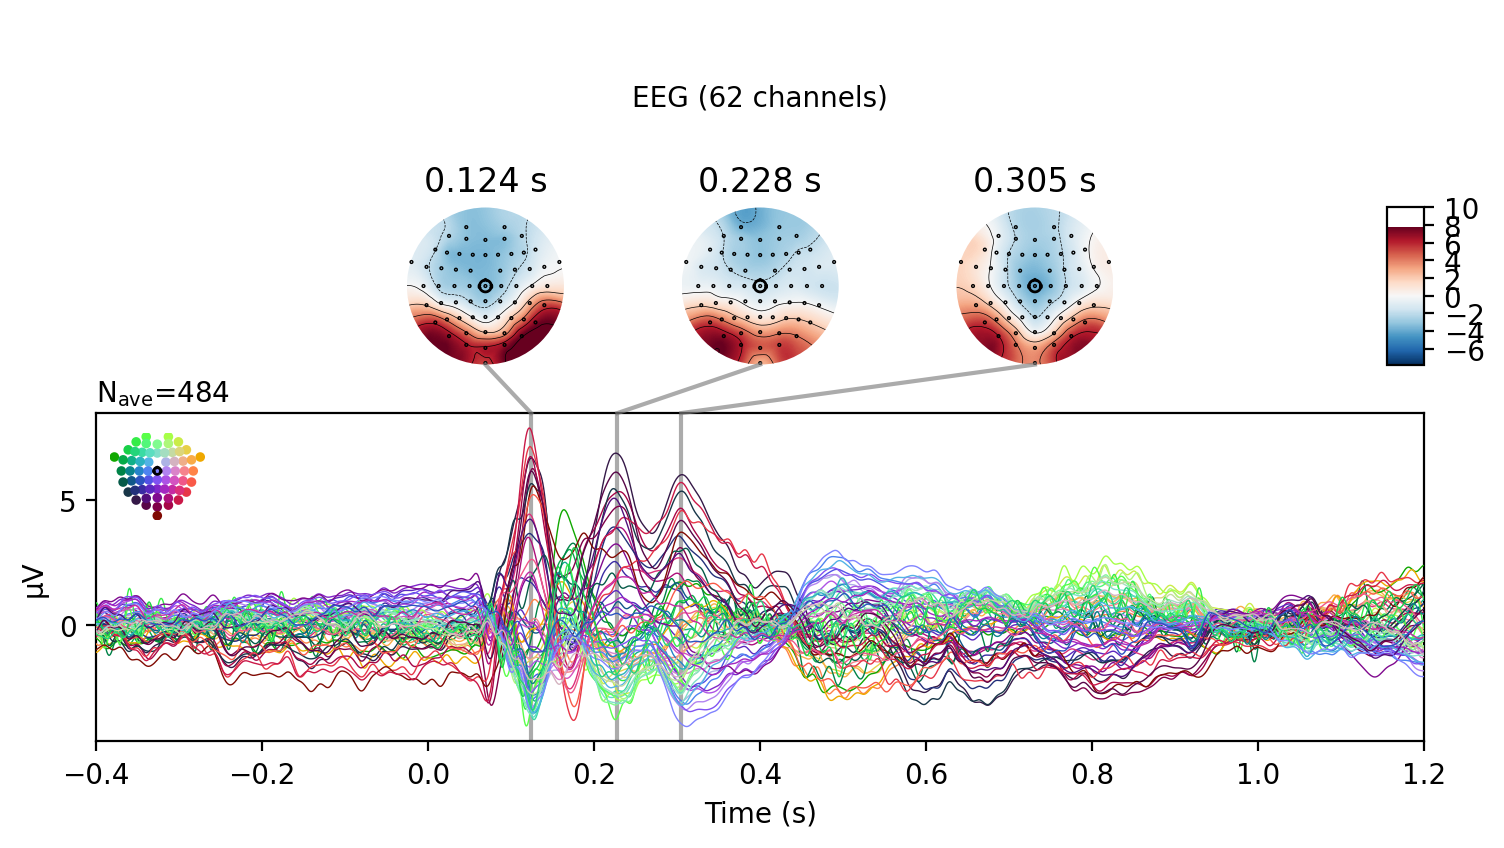

In [21]:
evoked_all.plot_joint()

In [9]:
evoked_all.plot_epochs(spatial_colors=True, gfp=True)

AttributeError: 'EvokedArray' object has no attribute 'plot_epochs'

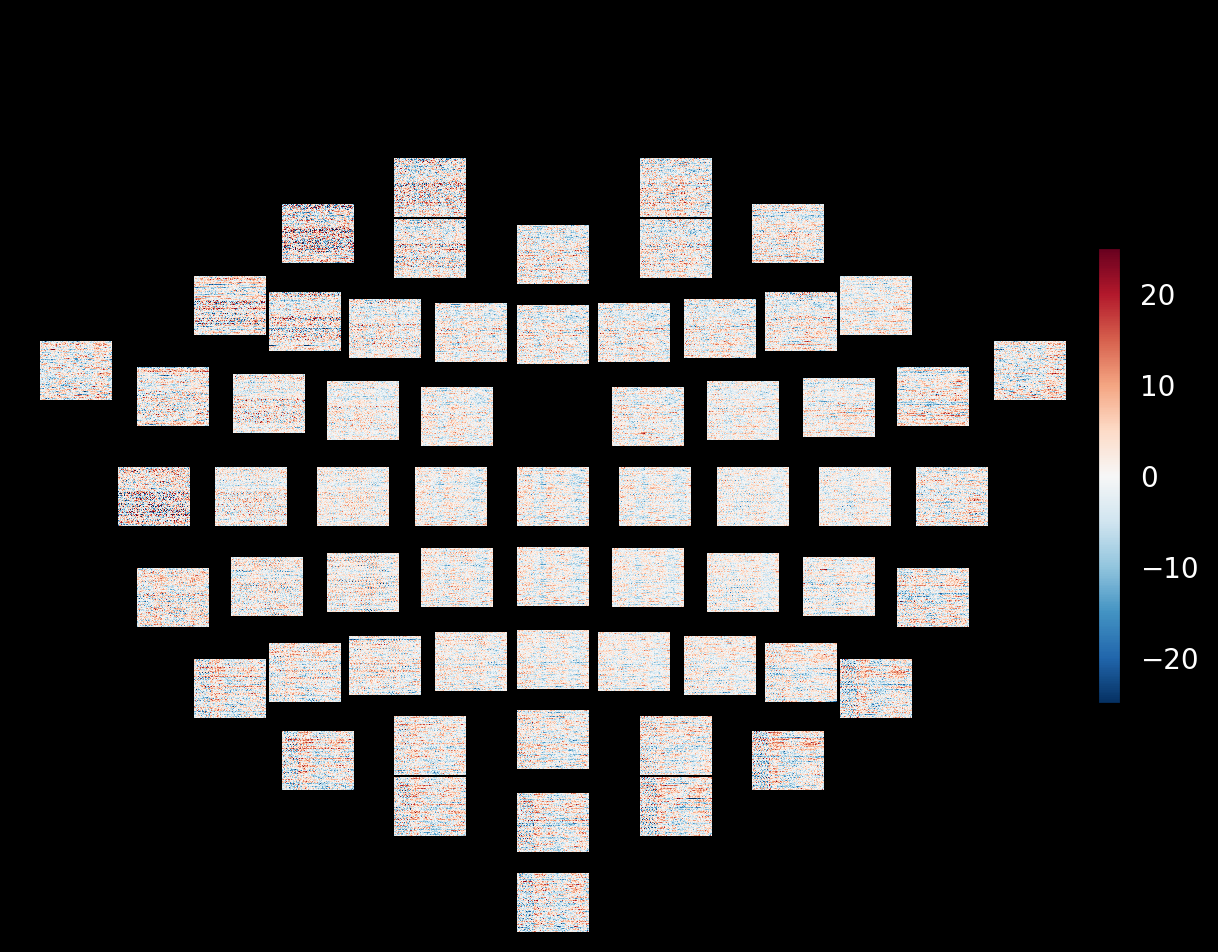

In [10]:
epoched_data.plot_topo_image(vmin=-25,vmax=25)

In [ ]:
evoked = epoched_data.average()
evoked.plot(time_unit='s')  # plot evoked response

In [22]:
conditions = ['Congruent', 'Incongruent', 'Neutral']
evokeds = {cond: epoched_data[cond].average() for cond in conditions}
conditions_kick = ['Congruent/Kick', 'Incongruent/Kick', 'Neutral/Kick']
evokeds_kick = {cond: epoched_data[cond].average() for cond in conditions_kick}
conditions_walk = ['Congruent/Walk', 'Incongruent/Walk', 'Neutral/Walk']
evokeds_walk = {cond: epoched_data[cond].average() for cond in conditions_walk}
conditions_left = ['Congruent/Left', 'Incongruent/Left', 'Neutral/Left']
evokeds_left = {cond: epoched_data[cond].average() for cond in conditions_left}
conditions_right = ['Congruent/Right', 'Incongruent/Right', 'Neutral/Right']
evokeds_right = {cond: epoched_data[cond].average() for cond in conditions_right}

In [16]:
for combine in ('mean', 'gfp'):
    mne.viz.plot_compare_evokeds(evokeds, picks='eeg', combine=combine)

combining channels using "mean"
combining channels using "mean"
combining channels using "mean"
combining channels using "gfp"
combining channels using "gfp"
combining channels using "gfp"


In [23]:
mne.viz.plot_compare_evokeds(evokeds,axes='topo')

[<Figure size 2880x1494 with 63 Axes>]

In [ ]:
mne.viz.plot_compare_evokeds(evokeds,axes='topo')

In [ ]:
evokeds.plot_topomap()

In [ ]:
evokeds['Congruent'].plot_image(picks='eeg')


In [ ]:
evokeds['Incongruent'].plot_image(picks='eeg')

In [ ]:
(evokeds['Incongruent']evokeds['Congruent']).plot_image(picks='eeg')

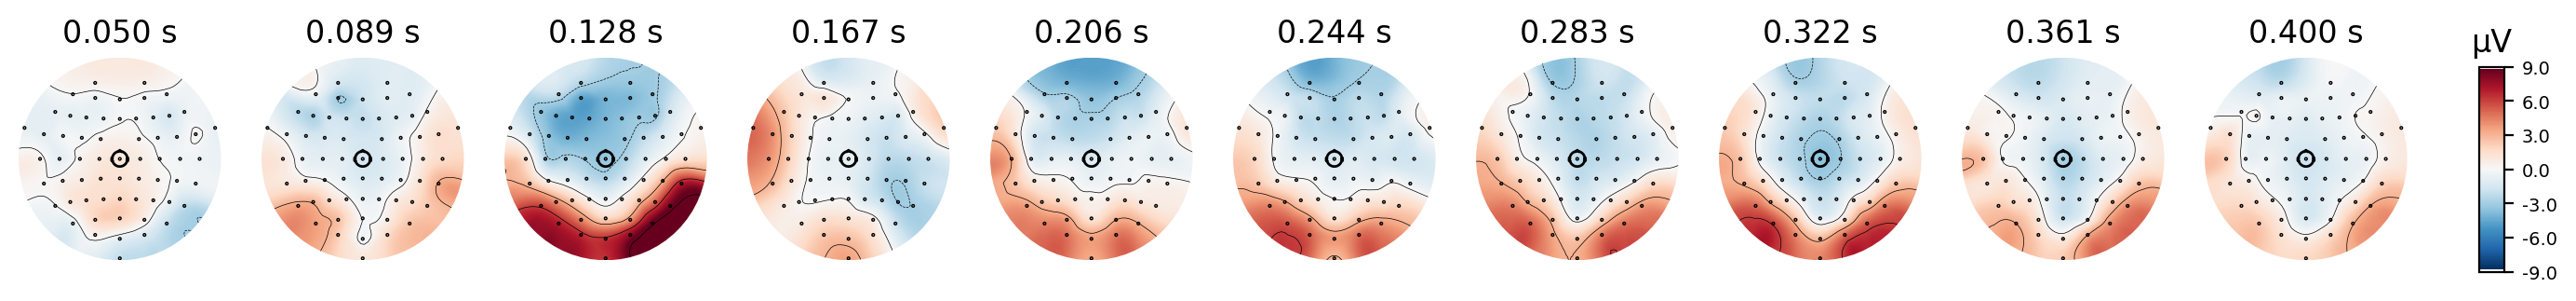

In [25]:
times = np.linspace(0.050, 0.400, 10)
evokeds['Incongruent'].plot_topomap(times=times, colorbar=True)


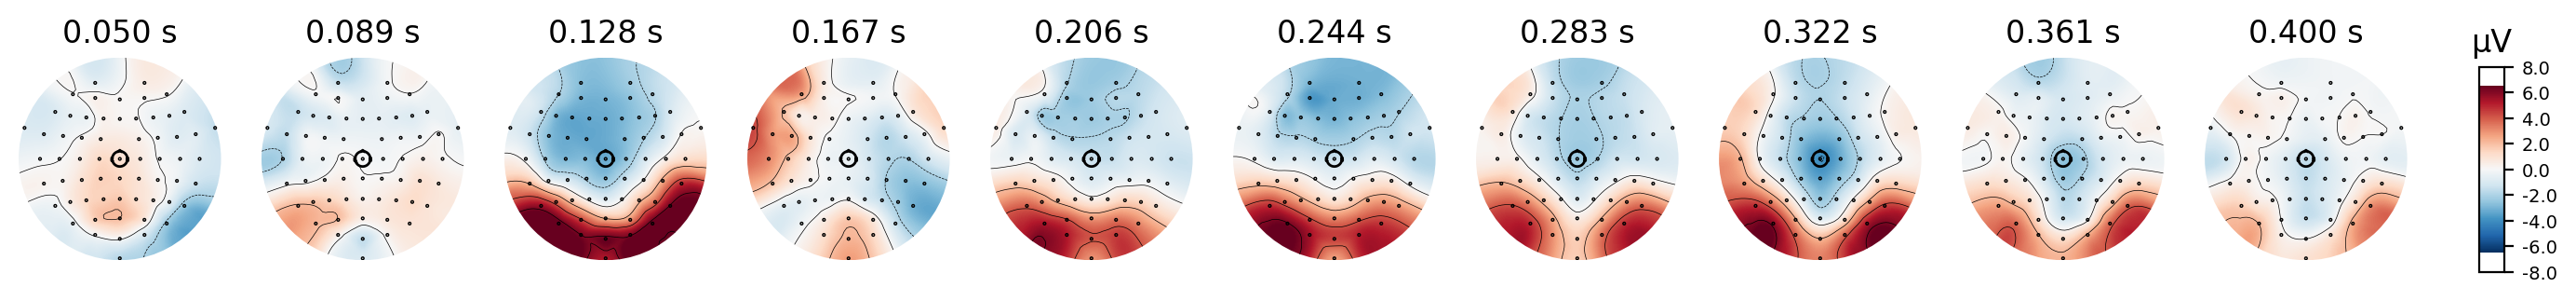

In [26]:
times = np.linspace(0.050, 0.400, 10)
evokeds['Congruent'].plot_topomap(times=times, colorbar=True)

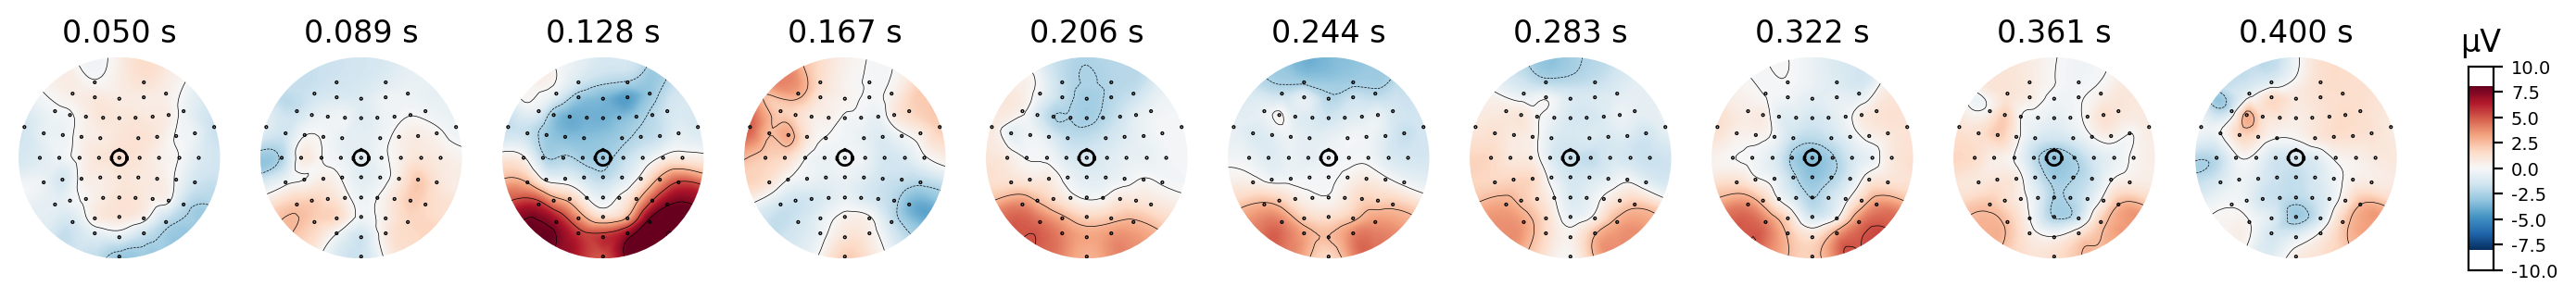

In [27]:
times = np.linspace(0.050, 0.400, 10)
evokeds['Neutral'].plot_topomap(times=times, colorbar=True)

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(epoched_data, freqs=freqs, n_cycles=n_cycles, use_fft=True,
                        return_itc=True, decim=3, n_jobs=-1)

In [ ]:
power.plot_topo(mode='logratio', title='Average power')
power.plot([82], mode='logratio', title=power.ch_names[82])

fig, axis = plt.subplots(1, 2, figsize=(7, 4))
power.plot_topomap(ch_type='grad', fmin=8, fmax=12, mode='logratio', axes=axis[0],
                   title='Alpha', show=False)
power.plot_topomap(ch_type='grad',fmin=13, fmax=25, mode='logratio', axes=axis[1],
                   title='Beta', show=False)
mne.viz.tight_layout()
plt.show()

In [ ]:
f, ax = plt.subplots()
psds, freqs = mne.time_frequency.psd_multitaper(epoched_data, fmin=2, fmax=40, n_jobs=1)
psds = 10 * np.log10(psds)  # convert to dB
psds_mean = psds.mean(0).mean(0)
psds_std = psds.mean(0).std(0)

ax.plot(freqs, psds_mean, color='k')
ax.fill_between(freqs, psds_mean - psds_std, psds_mean + psds_std,
                color='k', alpha=.5)
ax.set(title='Multitaper PSD (gradiometers)', xlabel='Frequency (Hz)',
       ylabel='Power Spectral Density (dB)')
plt.show()

In [ ]:
freqs = np.arange(2, 50)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = [-2.4, -2.2]  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test

In [ ]:
tfr = tfr_multitaper(epoched_data, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2,n_jobs=-1)


In [ ]:
tfr

In [ ]:
for event in event_dict:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        if len(c1)==0:
            c = np.asarray(c2)
            p = np.asarray(p2)
        elif len(c2)==0:
            c = np.asarray(c1)
            p = np.asarray(p1)
        else:
            c = np.stack(c1 + c2, axis=2)  # combined clusters
            p = np.concatenate((p1, p2))  # combined p-values
        
        mask = c[p <= 0.05,...].squeeze()

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epoched_data.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [ ]:
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [ ]:
frequency_map = list()

for band, fmin, fmax in iter_freqs:
    temp_epoched = tfr_epoched.copy()
    # bandpass filter
    temp_epoched.filter(fmin, fmax, n_jobs=-1, l_trans_bandwidth=1, h_trans_bandwidth=1,filter_length='auto') 

    # remove evoked response
    temp_epoched.subtract_evoked()

    # get analytic signal (envelope)
    temp_epoched.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), temp_epoched.average()))
    del temp_epoched

In [ ]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(-2400, -2200))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(-2.400, -2.200))
    ci_up = rescale(ci_up, average.times, baseline=(-2.400, -2.200))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [ ]:
gfp.time